In [2]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Simulate data

In [4]:
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)

In [5]:
paradigm.shape

(150, 240, 135)

In [6]:
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]

x, y = np.meshgrid(np.linspace(-.75, .75, 3), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 3))

In [7]:
parameters = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':1,
               'baseline':0.0}).astype(np.float32)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

In [1]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel

In [8]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))

2025-01-21 15:24:58.040280: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-21 15:24:58.040300: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-21 15:24:58.040305: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-21 15:24:58.040340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-21 15:24:58.040349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-01-21 15:24:58.203052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


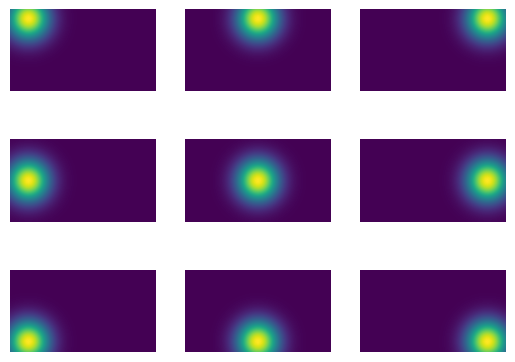

In [9]:
for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(model.get_rf()[i].reshape((240, 135)).T)
    plt.axis("off")

## Predictions (no noise)

<Axes: xlabel='frame'>

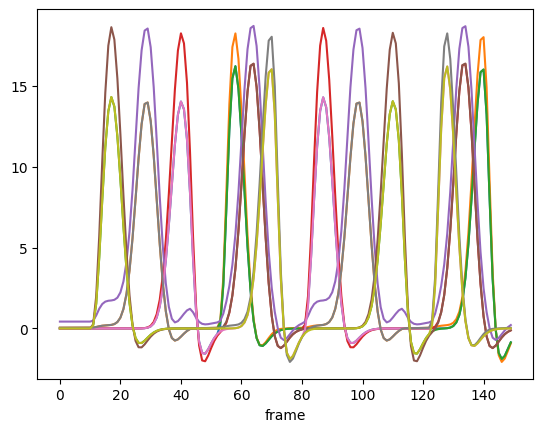

In [10]:
pred = model.predict()
pred.plot(legend=False)

## Noisy predictions

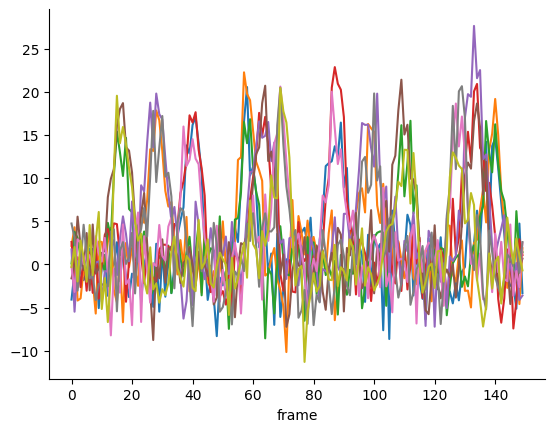

In [17]:
data = model.simulate(noise=3)
data.plot(legend=False)
sns.despine()

# Estimate parameters

In [12]:
from braincoder.optimize import ParameterFitter
from braincoder.bprf_mcmc import BPRF

/Users/marcusdaghlian/miniforge3/envs/tf-metal/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
cfitter = ParameterFitter(model, data, paradigm)


grid_pars = cfitter.fit_grid(x=np.linspace(-1, 1, 40), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 10),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars)

Working with chunk size of 493827
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 9


Current R2: 0.76281/Best R2: 0.76281:  17%|█▋        | 174/1000 [00:03<00:18, 45.16it/s]


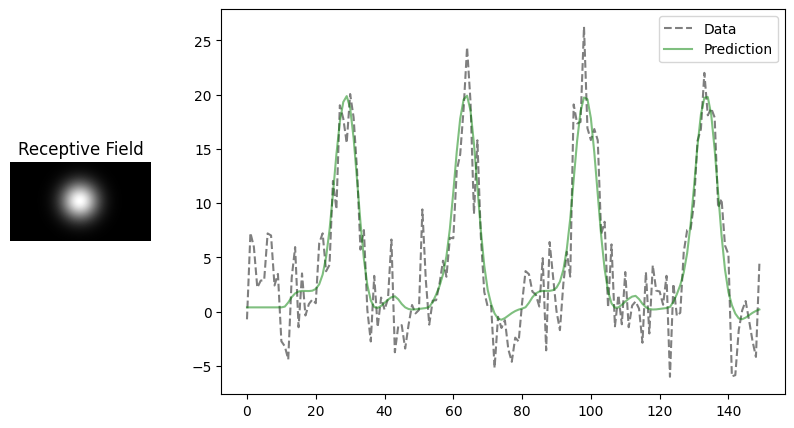

In [15]:
idx = 4
from braincoder.utils.visualize import quick_plot
quick_plot(
    model=model, 
    parameters=refined_pars.iloc[idx,:],
    data=data.iloc[:,idx]

)

In [19]:
bounds = {
    'x' : [-5, 5],
    'y' : [-5, 5],
    'sd' : [0, 10],
    'baseline' : [-2,2],
    'amplitude' : [0, 100], 
}
bfitter = BPRF(model=model, data=data, )
bfitter.add_priors_from_bounds(bounds)

### test the mcmc

In [20]:
n_vx = 9
init_pars = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.ones(n_vx),
    'amplitude' : np.ones(n_vx),
    'baseline' : np.zeros(n_vx),

})

In [314]:
bfitter.add_prior(
    pid='x', prior_type='normal', loc=0, scale=3
)

bfitter.add_prior(
    pid='y', prior_type='normal', loc=0, scale=3
)

In [21]:
# init_pars = 

a = bfitter.fit(
    idx=[0], 
    init_pars=init_pars,
    num_results=100,     
    #ols_pars,
    # fixed_pars={'baseline' : 0.0}
)

x
y
sd
baseline
amplitude


2025-01-21 15:27:12.864660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-21 15:27:13.030959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-21 15:27:13.325678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-21 15:27:13.572051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-21 15:27:13.576176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-01-21 15:27:13.595613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

In [ ]:
rsq = bfitter.get_rsq_for_idx(0, a[0])

In [ ]:
a

In [ ]:
def log1(residuals, sigmahat):
    log_like = -0.5 * np.sum((residuals / sigmahat) ** 2 + np.log(2 * np.pi * sigmahat**2))
    return log_like

def log2(residuals, sigmahat):
    # Use scipy to compute the log likelihood
    from scipy.stats import norm
    log_like = np.sum(norm.logpdf(residuals, scale=sigmahat))
    return log_like

def log3(residuals, sigmahat):
    # use tf to compute the log likelihood
    import tensorflow as tf
    import tensorflow_probability as tfp
    log_like = tf.reduce_sum(tfp.distributions.Normal(0, sigmahat).log_prob(residuals))
    return log_like
# Test are they different
residuals = np.random.randn(100)
sigmahat = 1

log1(residuals, sigmahat), log2(residuals, sigmahat), log3(residuals, sigmahat)



In [ ]:
plt.hist(rsq, bins=20)

In [ ]:
print(cfitter.get_rsq(refined_pars)[0])
print(rsq.max())

In [ ]:
bfitter.data.iloc[:,0].shape

In [77]:
preds = bfitter.model.predict(parameters=a)


In [ ]:
# plt.plot(bfitter.data.iloc[:,0])
plt.plot(preds)

In [ ]:
a.iloc[:1,:]

In [ ]:
import corner
labels = a.columns
f1 = corner.corner(
    a.iloc[0:-1,:],
    labels=labels,
    #   range={
    # truths=parameters.iloc[0,:].to_dict(),
    # range=[
    #     bounds[i] for i in bounds.keys() 
    # ]
    )
truths = parameters.iloc[0,:].to_dict()
total_ax = len(f1.axes)
nr = int(np.sqrt(total_ax))
for ax in f1.axes:
    irow = f1.axes.index(ax) // nr
    id_row = labels[irow]    
    icol = f1.axes.index(ax) % nr
    id_col = labels[icol]
    xname = ax.get_xlabel()
    yname = ax.get_ylabel()
    if icol == irow:
        
        ax.set_xlim(bounds[id_col])
        # ax.vline(truths[id_col], color='r')
    elif icol < irow:
        pass
        # ax.set_xlim(bounds[id_col])
        # ax.set_ylim(bounds[id_row])
        # ax.plot(truths[id_col], truths[id_row], 'ro')
    
    #     ax.set_xlim(bounds[])
    #     ax.axvline(truths[xname], color='r')
    # if yname in bounds.keys():
    #     ax.set_ylim(bounds[yname])
    #     ax.axhline(truths[yname], color='r')


In [ ]:
ax

In [ ]:
ir = f1.axes.index(ax)
ir

In [ ]:
range=[
    bounds[i] for i in bounds.keys() 
]
range

In [ ]:
f1.axes[0].get_ylabel()

In [ ]:
bbb.get_ylabel()

In [ ]:
parameters.iloc[0,:]

In [ ]:
range=[
    bounds[i] for i in bounds.keys() 
]
range

In [ ]:
a

In [ ]:
plt.plot(a.iloc[:,1])

In [ ]:
parameters.iloc[0,:]

In [ ]:
refined_pars = fitter.fit(init_pars=ols_pars, learning_rate=0.0001)

In [ ]:
refined_pars

In [ ]:
r2 = fitter.get_rsq(refined_pars)
r2

# Mexican hat model

In [27]:
from braincoder.models import DifferenceOfGaussiansPRF2DWithHRF

In [30]:
parameters_dog = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.001,
               'baseline':0.0,
               'srf_amplitude':.6, 
               'srf_size':2.}).astype(np.float32)

In [31]:
model_dog = DifferenceOfGaussiansPRF2DWithHRF(grid_coordinates, paradigm, parameters=parameters_dog,
                                             hrf_model=SPMHRFModel(tr=1.8))

In [ ]:
pred_dog = model_dog.predict()

In [ ]:
pred[0].plot()
pred_dog[0].plot()

In [ ]:
data_dog = model.simulate(noise=.001)
data_dog.plot(legend=False)
sns.despine()

In [25]:
fitter = ParameterFitter(model_dog, data_dog, paradigm)

In [26]:
est_pars_dog = refined_pars.copy()
est_pars_dog['srf_amplitude'] = 0.1
est_pars_dog['srf_factor'] = 2.

In [ ]:
est_pars_dog = fitter.fit(init_pars=est_pars_dog, learning_rate=0.001)

In [ ]:
est_pred = model.predict(parameters=est_pars_dog)

In [ ]:
est_pred[1].plot()
pred_dog[1].plot()
data_dog[1].plot()

In [ ]:
est_pars_dog

In [ ]:
parameters_dog

In [ ]:
r2 = fitter.get_rsq()

In [ ]:
r2